# NBA Rookie Career Prediction - Modelling with sklearn
by Kevin Götz

## Table of Contents

1. Import Modules & Data
2. Review of EDA Results 
3. Data Preprocessing
    - 3.1 Encoding, Imputation & Scaling / Transforming
    - 3.2 Dimensionality Reduction with PCA
    - 3.3 Feature Selection with RFE
4. Model Comparison
5. Building an Ensemble Meta-Estimator
6. Hyperparametertuning
7. Model Evaluation
8. Model Inspection
9. Finalization & Prediction
10. Visualizing the Pipeline
11. Conclusion

## 1. Import Modules & Data

### Checking the Virtual Environment (venv)

In [1]:
# first check if the venv is correct
!where python

C:\Users\Kevin G�tz\venv\nba_rookie\Scripts\python.exe
C:\Users\Kevin G�tz\AppData\Local\Programs\Python\Python310\python.exe
C:\Users\Kevin G�tz\AppData\Local\Programs\Python\Python38\python.exe
C:\Users\Kevin G�tz\AppData\Local\Programs\Python\Python39\python.exe
C:\Users\Kevin G�tz\AppData\Local\Microsoft\WindowsApps\python.exe


### Importing the Modules

In [93]:
# data munging
import pandas as pd 
import numpy as np 

# Preprocessing
from sklearn.preprocessing import StandardScaler, PowerTransformer, OrdinalEncoder, OneHotEncoder, FunctionTransformer
from category_encoders.target_encoder import TargetEncoder
from sklearn.impute import KNNImputer, SimpleImputer

# Custom Transformer
from sklearn.base import BaseEstimator, TransformerMixin

# Feature Selection
from yellowbrick.model_selection import RFECV, FeatureImportances
from sklearn.decomposition import PCA 
from sklearn.feature_selection import RFE
# from sklearn.inspection import permutation_importance

# Pipeline
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor

# Models
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, ExtraTreesRegressor, VotingRegressor
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

# Evaluation & Tuning
from yellowbrick.model_selection import LearningCurve, ValidationCurve
from yellowbrick.regressor import ResidualsPlot, PredictionError
from sklearn.model_selection import train_test_split, cross_val_score, ParameterGrid, RandomizedSearchCV, KFold

# Saving the model
import joblib

# visualization & Evaluation
import matplotlib.pyplot as plt 
%matplotlib inline
import seaborn as sns 
from IPython.core.display import display, HTML
from sklearn.utils import estimator_html_repr

# settings
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max.columns', None)
pd.set_option('display.precision', 2)

### Importing the Data

In [3]:
# load the training & test data
veterans_train = pd.read_csv('../Data/Output/NBA_Player_Stats_Veterans_Train.csv', index_col=0)
veterans_test = pd.read_csv('../Data/Output/NBA_Player_Stats_Veterans_Test.csv', index_col=0)

# show df
print(f'train set: {veterans_train.shape}')
display(veterans_train.head())

print(f'test set: {veterans_test.shape}')
display(veterans_test.head())

train set: (405, 31)


,namePlayer,numberPickOverall,nameOrganizationFrom,typeOrganizationFrom,Age,Tm,Pos,G,GS,MP,FG,FG%,3P,3P%,2P,2P%,eFG%,FT,FT%,ORB,DRB,AST,STL,BLK,TOV,PF,PTS,PER,WS,WS/48,Career_PER
413,Zaza Pachulia,42.0,Ulkerspor,Other Team/Club,19.0,ORL,C,59.0,2.0,11.3,1.2,0.39,0.0,NaN,1.2,0.39,0.39,1.0,0.64,1.2,1.8,0.2,0.4,0.2,0.6,1.5,3.3,10.8,0.3,2.30e-02,14.6
195,Jordan Crawford,27.0,Xavier,College/University,22.0,TOT,SG,42.0,18.0,24.5,4.6,0.38,0.8,0.26,3.8,0.43,0.42,1.7,0.87,0.7,1.8,2.8,0.9,0.1,2.0,1.5,11.7,11.8,-0.6,-2.60e-02,14.1
197,Hassan Whiteside,33.0,Marshall,College/University,21.0,SAC,C,1.0,0.0,2.0,0.0,NaN,0.0,NaN,0.0,NaN,NaN,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,-17.9,0.0,7.00e-03,24.0
92,Shabazz Muhammad,14.0,California-Los Angeles,College/University,21.0,MIN,SG,37.0,0.0,7.8,1.5,0.46,0.1,0.27,1.5,0.48,0.47,0.7,0.65,0.6,0.8,0.2,0.2,0.0,0.4,0.6,3.9,13.1,0.3,5.30e-02,15.9
146,Brandon Knight,8.0,Kentucky,College/University,20.0,DET,PG,66.0,60.0,32.3,4.8,0.41,1.6,0.38,3.2,0.43,0.48,1.6,0.76,0.5,2.7,3.8,0.7,0.2,2.6,2.3,12.8,11.7,1.3,2.90e-02,13.7


test set: (102, 31)


,namePlayer,numberPickOverall,nameOrganizationFrom,typeOrganizationFrom,Age,Tm,Pos,G,GS,MP,FG,FG%,3P,3P%,2P,2P%,eFG%,FT,FT%,ORB,DRB,AST,STL,BLK,TOV,PF,PTS,PER,WS,WS/48,Career_PER
338,Hakim Warrick,19.0,Syracuse,College/University,23.0,MEM,PF,68.0,2.0,10.6,1.5,0.44,0.0,NaN,1.5,0.44,0.44,1.1,0.66,0.6,1.5,0.4,0.2,0.3,0.8,1.7,4.1,11.0,0.8,5.30e-02,15.5
30,Emmanuel Mudiay,7.0,Guangdong Southern Tigers,Other Team/Club,19.0,DEN,PG,68.0,66.0,30.4,4.8,0.36,1.1,0.32,3.8,0.38,0.40,2.1,0.67,0.5,2.9,5.5,1.0,0.5,3.2,2.1,12.8,9.9,-2.1,-4.90e-02,11.8
495,DeShawn Stevenson,23.0,Washington Union,High School,19.0,UTA,SG,40.0,2.0,7.3,0.8,0.34,0.0,0.08,0.8,0.38,0.35,0.7,0.68,0.2,0.5,0.5,0.3,0.1,0.7,0.7,2.2,4.3,-0.4,-7.10e-02,9.9
240,D.J. Augustin,9.0,Texas,College/University,21.0,CHA,PG,72.0,12.0,26.5,3.7,0.43,1.5,0.44,2.2,0.42,0.52,2.9,0.89,0.2,1.6,3.5,0.6,0.0,1.7,1.9,11.8,14.9,5.1,1.28e-01,14.1
162,Cory Joseph,29.0,Texas,College/University,20.0,SAS,PG,29.0,1.0,9.2,0.8,0.31,0.1,0.20,0.7,0.34,0.34,0.4,0.65,0.2,0.7,1.2,0.2,0.1,0.4,0.6,2.0,6.9,0.0,1.00e-03,12.2


## 2. Review of EDA Results
- namePlayer is not relevant for the prediction accuracy but is carried over for inspection of final results
- nameOrganizationFrom has a high cardinality (149 = 41.3% distinct) and should therefore be target encoded (for dimensionality reduction)
- There are a lot of high correlations which could distort the regression analysis (if linear) due to multicollinearity --> PCA
- The predictors '3P', '3P%' and 'FT%' have a low overall correlation with the target 'Career_PER' but they have higher correlations for the subgroups of positions so they will be kept for prediction
- the position label 'PF,SF' does only appear once and should therefore be labeled as missing, which is done in the one-hot encoding later on
- The missings in the categorical variables will be dealt with a one-hot encoded variable for missings. Most frequent makes no sense for such high cardinality and assumes MCAR (Missing Completely at Random)
- the missings in the numerical data are only for FG%, FT%, 3P%, 2P% and eFG%. This is dealt with a KNN Imputer for better accuracy
- The distribution of the predictors is mostly not normal, so a PowerTransformer will be applied
- Automatic Removal of Outliers with iForest will not be applied because the outliers seem to be natural outliers (gifted and ungifted players, we also try to predict that) after inspecting them

## 3. Data Preprocessing

Data Preprocessing is the biggest part in this notebook. It encompasses a ml pipeline for Imputation, Encoding, Scaling, Transforming, Dimensionality Reduction, Feature Selection, etc. and is crucial for the accuracy of the model and necessary for some linear models. The features were splitted into their level of measurement (nominal, ordinal, interval & ratio) to be treated accordingly. The final preprocessing can be viewed in the last step when a HTML representation of the whole pipeline is created.

In [4]:
# feature-target-split
X_train = veterans_train.drop('Career_PER', axis=1)
y_train = veterans_train['Career_PER']

In [5]:
# select the different dtypes

numeric_features = X_train.select_dtypes(include=np.number).columns.to_list()  # np.number for float and int in all sizes
print('The numerical features are:', numeric_features, sep='\n', end='\n\n')

categorical_features = X_train.select_dtypes(include=['string', 'object']).columns.to_list()  # if convert_dtypes() was applied: string; else: object
print('The categorical features are:', categorical_features, sep='\n')

The numerical features are:
['numberPickOverall', 'Age', 'G', 'GS', 'MP', 'FG', 'FG%', '3P', '3P%', '2P', '2P%', 'eFG%', 'FT', 'FT%', 'ORB', 'DRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', 'PER', 'WS', 'WS/48']

The categorical features are:
['namePlayer', 'nameOrganizationFrom', 'typeOrganizationFrom', 'Tm', 'Pos']


--> **numerical features**: NumberPickOverall is scaled ordinally which is important for encoding

--> **categorical features**: namePlayer is not important for prediction but for explanation / inspection and nameOrganizationFrom + Tm has has many categories and is therefore target-encoded

## 3.1 Encoding, Imputation & Scaling / Transforming

### Define the columns for the different Preprocessing Pipelines

In [6]:
# columns by level of measurement / type of encoding

onehot_columns = ['typeOrganizationFrom', 'Pos']
target_columns = ['nameOrganizationFrom', 'Tm']
ordinal_columns = ['numberPickOverall']
ratio_columns = ['Age', 'G', 'GS', 'MP', 'FG', 'FG%', '3P', '3P%', '2P', '2P%', 'eFG%', 'FT', \
                 'FT%', 'ORB', 'DRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', 'PER', 'WS', 'WS/48']

### Define the Encoders

In [7]:
# if new category during transform than all onehot columns equal 0 + explicit categories because wrong categories may be in the train set already
OHE_Pos = OneHotEncoder(categories=[['PG', 'SG', 'PF', 'SF', 'C']], drop='if_binary', sparse=False, handle_unknown='ignore')
OHE_Org = OneHotEncoder(categories=[['College/University', 'High School', 'Other Team/Club']], drop='if_binary', sparse=False, handle_unknown='ignore')

# the most frequent categories appear 19 times, some only once
TE = TargetEncoder(drop_invariant=True, handle_missing='return_nan', handle_unknown='value', smoothing=5)

# position 1-60 is possible. If unknown, then np.nan and KNN impute later on
cats = sorted(set(X_train.numberPickOverall))
OE = OrdinalEncoder(categories=[cats], handle_unknown='use_encoded_value', unknown_value=np.nan)

### Define the Imputers

In [8]:
# weights should be uniform because data is not scaled beforehand (to take imputed data into consideration for mean-computation the scaling has to be done afterwards)
KNNI_numeric = KNNImputer(missing_values=np.nan, n_neighbors=5, weights='uniform', metric='nan_euclidean')

# for categorical (nominal/ordinal) only n_beighbors=1 makes sense because an average with categories makes no sense (here: avg(pick1, pick2) = pick1.5??)
KNNI_ordinal = KNNImputer(missing_values=np.nan, n_neighbors=1, metric='nan_euclidean')

# we could also use a KNNI for nominal features in combination with LabelEncoder (preserving np.nan) but choose not to because it's probably not MCAR as seen in EDA
SI = SimpleImputer(missing_values=np.nan, strategy='constant', fill_value='missing')

### Define the Scaling / Transforming

In [9]:
# scaling before transforming can lift the model performance: https://machinelearningmastery.com/power-transforms-with-scikit-learn/

SS = StandardScaler()
PT = PowerTransformer(method='yeo-johnson', standardize=True)

### Building the Pipelines

In [10]:
# theres a specific Pipeline for every column that needs to be treated differently

onehot_org_pipeline = Pipeline(
    steps=[
        ('SI', SI),
        ('OHE_Org', OHE_Org)])

onehot_pos_pipeline = Pipeline(
    steps=[
        ('SI', SI),
        ('OHE_Pos', OHE_Pos)])

target_pipeline = Pipeline(
    steps=[
        ('TE', TE),
        ('KNNI_numeric', KNNI_numeric),
        ('SS', SS),
        ('PT', PT)])

ordinal_pipeline = Pipeline(
    steps=[
        ('OE', OE),
        ('KNNI_ordinal', KNNI_ordinal)])

ratio_pipeline = Pipeline(
    steps=[
        ('KNNI', KNNI_numeric),
        ('SS', SS),
        ('PT', PT)])

### Define the ColumnTransformer

In [11]:
# build the preprocessor with the combined pipelines

preprocessor = ColumnTransformer(
    transformers=[
        ('passNames', 'passthrough', ['namePlayer']),
        ('onehot_org', onehot_org_pipeline, ['typeOrganizationFrom']),
        ('onehot_pos', onehot_pos_pipeline, ['Pos']),
        ('target', target_pipeline, target_columns),
        ('ordinal', ordinal_pipeline, ordinal_columns),
        ('ratio', ratio_pipeline, ratio_columns)],
    remainder='drop',
    n_jobs=-1)

### Inspect the transformed DataFrame

- First we inspect the DataFrame before and after to see if the correct columns changed in the expected way (onehot, scaling)
- second we check the distribution for the power-transformed variables
- third we check the data for missings (should be none after imputation)

In [ ]:
# fit the ColumnTransformer to the data (supervised because of TargetEncoder)
preprocessor.fit(X_train, y_train)

In [13]:
# get column names of transformed array
passthrough_columns = ['namePlayer']
onehot_columns_school = list(preprocessor.named_transformers_['onehot_org']['OHE_Org'].get_feature_names_out())
onehot_columns_position = list(preprocessor.named_transformers_['onehot_pos']['OHE_Pos'].get_feature_names_out())
columns = passthrough_columns + onehot_columns_school + onehot_columns_position + target_columns + ordinal_columns + ratio_columns
index = X_train.index

In [14]:
# Inspect training data before and after
print("******************** Training Data Original ********************")
display(X_train.head(3))

print("****************** Training Data Transformed *******************")
X_prep = pd.DataFrame(preprocessor.transform(X_train), columns=columns, index=index)  # table to inspect results of PCA for later
display(X_prep.head(3))

******************** Training Data Original ********************


,namePlayer,numberPickOverall,nameOrganizationFrom,typeOrganizationFrom,Age,Tm,Pos,G,GS,MP,FG,FG%,3P,3P%,2P,2P%,eFG%,FT,FT%,ORB,DRB,AST,STL,BLK,TOV,PF,PTS,PER,WS,WS/48
413,Zaza Pachulia,42.0,Ulkerspor,Other Team/Club,19.0,ORL,C,59.0,2.0,11.3,1.2,0.39,0.0,NaN,1.2,0.39,0.39,1.0,0.64,1.2,1.8,0.2,0.4,0.2,0.6,1.5,3.3,10.8,0.3,2.30e-02
195,Jordan Crawford,27.0,Xavier,College/University,22.0,TOT,SG,42.0,18.0,24.5,4.6,0.38,0.8,0.26,3.8,0.43,0.42,1.7,0.87,0.7,1.8,2.8,0.9,0.1,2.0,1.5,11.7,11.8,-0.6,-2.60e-02
197,Hassan Whiteside,33.0,Marshall,College/University,21.0,SAC,C,1.0,0.0,2.0,0.0,NaN,0.0,NaN,0.0,NaN,NaN,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,-17.9,0.0,7.00e-03


****************** Training Data Transformed *******************


,namePlayer,x0_College/University,x0_High School,x0_Other Team/Club,x0_PG,x0_SG,x0_PF,x0_SF,x0_C,nameOrganizationFrom,Tm,numberPickOverall,Age,G,GS,MP,FG,FG%,3P,3P%,2P,2P%,eFG%,FT,FT%,ORB,DRB,AST,STL,BLK,TOV,PF,PTS,PER,WS,WS/48
413,Zaza Pachulia,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.47,-0.48,41.0,-1.59,-0.16,-0.84,-0.71,-0.87,-0.61,-1.04,-0.94,-0.59,-0.93,-1.06,0.05,-0.61,0.64,-0.11,-1.32,-0.25,-0.37,-0.63,-0.35,-0.82,-0.32,-0.87,-0.62
195,Jordan Crawford,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.41,0.91,26.0,0.51,-0.84,0.43,0.88,1.35,-0.67,1.15,-0.03,1.28,-0.44,-0.69,0.85,1.33,-0.13,-0.11,1.37,1.07,-0.91,1.38,-0.35,1.29,-0.1,-1.98,-1.24
197,Hassan Whiteside,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.01,1.04,32.0,-0.14,-1.8,-1.06,-2.15,-2.35,0.29,-1.04,-0.04,-2.26,-0.28,0.17,-2.03,-0.99,-1.89,-2.22,-1.83,-2.07,-1.55,-2.46,0.3,-2.35,-5.52,-1.21,-0.83


--> The data looks good so far. Let's see if the distributions are transformed to gaussian

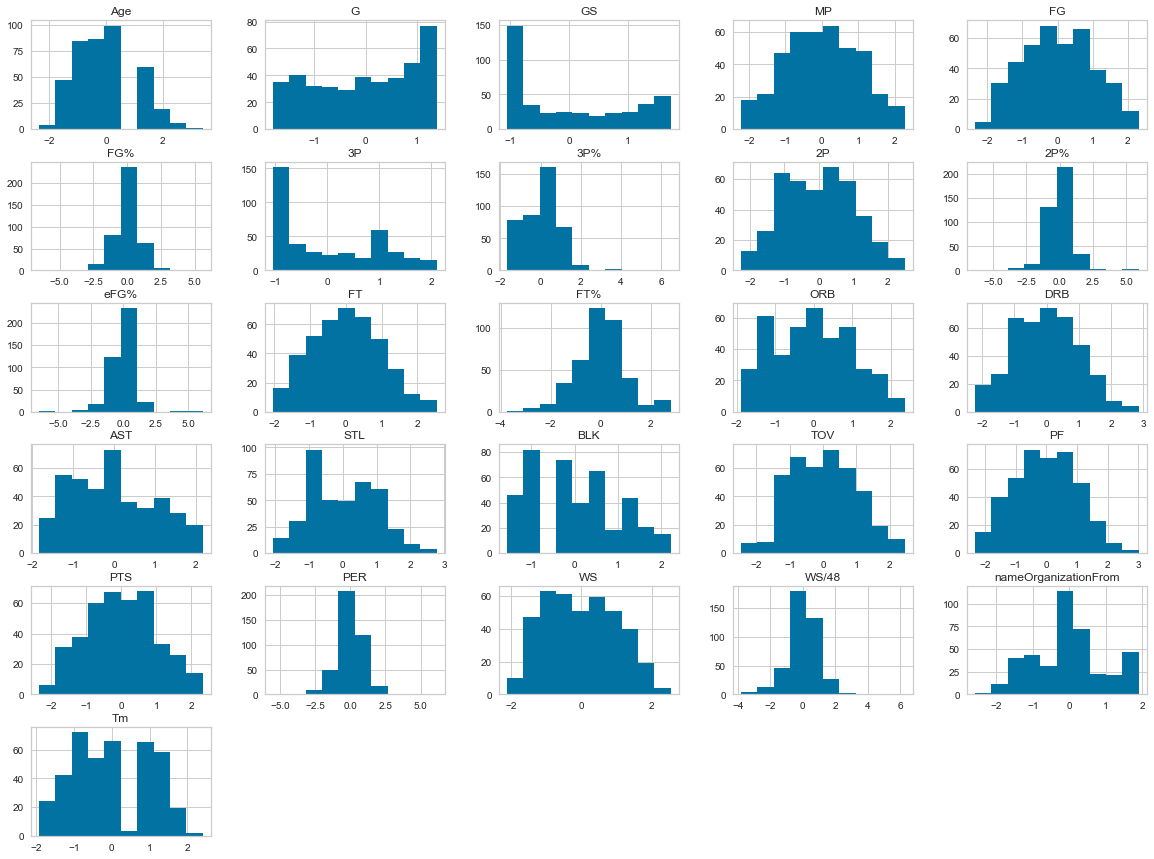

In [15]:
X_prep[ratio_columns + target_columns].convert_dtypes().hist(figsize=(20, 15))
plt.show()

--> Most of the data is transformed into a  gaussian like distribution. Some columns, like G, GS, 3P, 3P% & BLK, didn't respond good to the transformer and we could make use of the QuantileTransformer. BUT: Because it is a non-parametric method, it is harder to interpret than the parametric ones (Power transforms  with Box-Cox and Yeo-Johnson). On “small” datasets (less than a few hundred points), the quantile transformer is prone to overfitting.

In [16]:
# let's check for missings
X_prep.isna().sum().sum()

0

--> zero missings as expected, perfect!

In [18]:
# prepare the target (later done automatically in pipeline, just for testing reasons)
y_prep = PowerTransformer(method='yeo-johnson').fit_transform(StandardScaler().fit_transform(pd.DataFrame(y_train)))
y_prep = pd.DataFrame(y_prep, columns=['Career_PER'], index=index)
y_prep.head()

,Career_PER
413,0.23
195,0.08
197,2.18
92,0.57
146,-0.04


In [19]:
# safe the prepared df to disc
veterans_train_prep = pd.concat([X_prep, y_prep], axis=1)
veterans_train_prep.to_csv('../Data/Output/NBA_Player_Stats_Veterans_Train_Prep.csv')

## 3.2 Dimensionality Reduction with PCA

During the EDA it was obvious that some of the features correlate highly. PCA groups those features into components that are not correlated (orthogonal) and help in prediction accuracy. But first we look at the feature importance to decide which feature to keep out of PCA (if a feature has superior explanatory power we want to keep it extra).

In [20]:
# define the columns for PCA (high correlation features from EDA)
%pprint
corr_matrix = X_prep[ratio_columns + target_columns].convert_dtypes().corr().abs()
high_corr_var = np.where(corr_matrix > 0.7)
corr_columns = list(set([corr_matrix.columns[x] for x, y in zip(*high_corr_var) if x != y]))
corr_columns

Pretty printing has been turned OFF


['BLK', 'PER', 'FG', 'STL', 'AST', '2P%', 'WS', 'G', 'WS/48', 'GS', 'FG%', 'ORB', 'FT', 'PTS', 'MP', 'PF', 'TOV', '2P', 'DRB', 'eFG%']

### Feature Importances

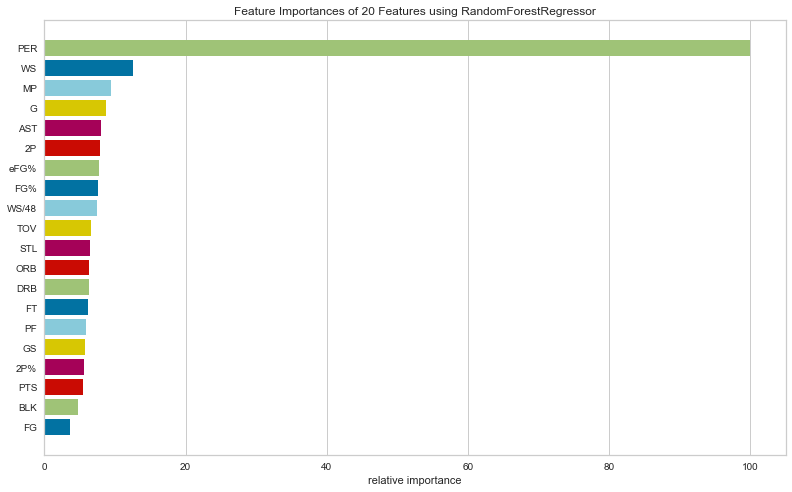

In [21]:
# let's view the feature importances of the Random Forest

model = RandomForestRegressor(n_estimators=50, n_jobs=-1)
viz_fi = FeatureImportances(model, size=(800, 500))
viz_fi.fit(X_prep[corr_columns], y_prep)  # don't fit on the players' names (first column)
viz_fi.finalize()

--> PER has by far the most predictive power so we keep it out of the PCA and include it as it is in the Pipeline later on

In [22]:
# drop the column "PER" from the list

corr_columns.remove('PER')
corr_columns

['BLK', 'FG', 'STL', 'AST', '2P%', 'WS', 'G', 'WS/48', 'GS', 'FG%', 'ORB', 'FT', 'PTS', 'MP', 'PF', 'TOV', '2P', 'DRB', 'eFG%']

In [23]:
# fit the PCA
pca = PCA(n_components=len(corr_columns), random_state=8)
pca.fit(X_prep[corr_columns])

PCA(n_components=19, random_state=8)

### Scree Plot to choose Number of Components

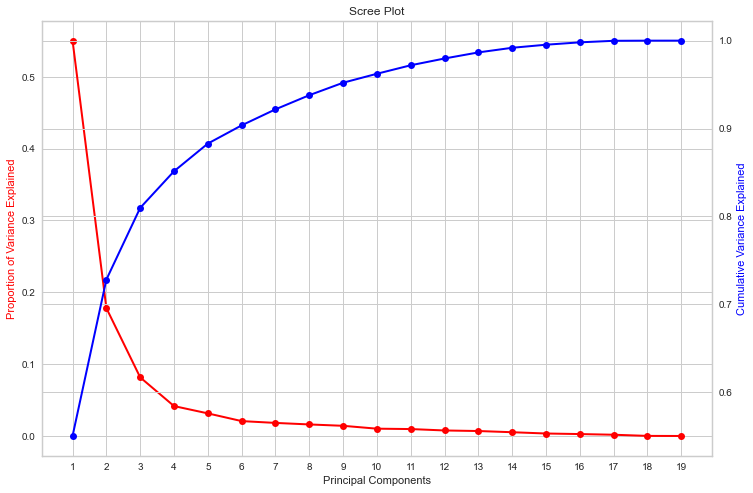

In [24]:
# set number of components for x-axis
PC_values = range(1, pca.n_components_ + 1)

# build figure 1
fig, ax = plt.subplots()
fig.set_figheight(8)
fig.set_figwidth(12)
ax.set_title('Scree Plot')
ax.figsize=(12, 8)
ax.plot(PC_values, pca.explained_variance_ratio_, color='red', marker='o', linewidth=2)
ax.set_xlabel('Principal Components')
ax.set_ylabel('Proportion of Variance Explained', color='red')
ax.set_xticks(PC_values)

# build figure 2
ax2 = ax.twinx()
ax2.plot(PC_values, np.cumsum(pca.explained_variance_ratio_), color='blue', marker='o', linewidth=2)
ax2.set_ylabel('Cumulative Variance Explained', color='blue')

# show dual axis plot
plt.show()

In [25]:
# let's see the Cumulative Variance Explained per number of Components

# cumulative explained Variance
expl_variance = np.cumsum(pca.explained_variance_ratio_).reshape(1, -1)
# Variance gain per additional Component
variance_gain = np.diff(expl_variance)
variance_gain = np.append(expl_variance[0, 0], variance_gain).reshape(1, -1)
# combine the information
var_info = np.vstack((expl_variance, variance_gain))

# show the df
pd.DataFrame(data=var_info, columns=PC_values, index=['explained Variance', 'Variance Gain'])

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
explained Variance,0.55,0.73,0.81,0.85,0.88,0.90,0.92,0.94,0.95,0.96,9.72e-01,9.80e-01,9.87e-01,9.92e-01,9.95e-01,9.98e-01,1.00e+00,1.00e+00,1.00e+00
Variance Gain,0.55,0.18,0.08,0.04,0.03,0.02,0.02,0.02,0.01,0.01,9.67e-03,7.71e-03,6.92e-03,5.26e-03,3.48e-03,2.70e-03,1.76e-03,1.56e-04,2.61e-05


--> 3-8 components could be ideal for the hyperparameter search. But the explained variance is an unsupervised metric and does not translate directly to better predictions. That's why we test several components during the hyperparameter tuning and evaluate on supervised metrics later on.

### Loading Scores

In [26]:
# let's see which features contribute to which components (Loading Scores = correlation of feature with component)

pca = PCA(n_components=3, random_state=8)
X_pca = pd.DataFrame(pca.fit_transform(X_prep[corr_columns]))
X_pca_contribute = pd.DataFrame(pca.components_, columns=X_prep[corr_columns].columns, index=['PC-' + str(n) for n in range(1, pca.n_components + 1)]).T
X_pca_contribute.style.background_gradient(cmap='coolwarm', axis=1)

,PC-1,PC-2,PC-3
BLK,-0.17,0.18,-0.49
FG,-0.29,-0.08,0.11
STL,-0.24,-0.19,0.16
AST,-0.20,-0.27,0.37
2P%,-0.10,0.45,0.28
WS,-0.25,0.12,-0.04
G,-0.23,-0.07,-0.03
WS/48,-0.13,0.35,0.02
GS,-0.25,-0.09,-0.04
FG%,-0.12,0.47,0.18


--> It's not quite clear what the loadings could mean in a business sense....but if only the predicitve capability of the model is important then interpretation is secondary.

### Build the new Pipeline with PCA

In [27]:
# ratio columns that are not included in the PCA (low correlation / PER)
ratio_columns_no_corr = list(set(ratio_columns).difference(set(corr_columns)))

In [28]:
# new pca pipeline
pca_pipeline = Pipeline(
    steps=[
        ('ratio_pipeline', ratio_pipeline),
        ('pca', PCA(n_components=3, random_state=8))])

# new preprocessor with pca
preprocessor = ColumnTransformer(
    transformers=[
        ('passNames', 'passthrough', ['namePlayer']),
        ('onehot_org', onehot_org_pipeline, ['typeOrganizationFrom']),
        ('onehot_pos', onehot_pos_pipeline, ['Pos']),
        ('target', target_pipeline, target_columns),
        ('ordinal', ordinal_pipeline, ordinal_columns),
        ('ratio', ratio_pipeline, ratio_columns_no_corr),
        ('pca', pca_pipeline, corr_columns)],
    remainder='drop',
    n_jobs=-1)

In [ ]:
# fit the preprocessor
preprocessor.fit(X_train, y_train)

In [30]:
## get the column names

# get number of components to name the principal components
n_components_pca = preprocessor.named_transformers_['pca'].named_steps['pca'].n_components

# columns
passthrough_columns = ['namePlayer']
onehot_columns_school = list(preprocessor.named_transformers_['onehot_org']['OHE_Org'].get_feature_names_out())
onehot_columns_position = list(preprocessor.named_transformers_['onehot_pos']['OHE_Pos'].get_feature_names_out())
columns = passthrough_columns + onehot_columns_school + onehot_columns_position + target_columns \
          + ordinal_columns + ratio_columns_no_corr + ['PC-' + str(i) for i in range(1, n_components_pca + 1)]

In [31]:
# view the preprocessed data
X_prep = pd.DataFrame(preprocessor.transform(X_train), columns=columns, index=X_train.index)
X_prep.head()

,namePlayer,x0_College/University,x0_High School,x0_Other Team/Club,x0_PG,x0_SG,x0_PF,x0_SF,x0_C,nameOrganizationFrom,Tm,numberPickOverall,Age,3P%,PER,3P,FT%,PC-1,PC-2,PC-3
413,Zaza Pachulia,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.47,-0.48,41.0,-1.59,-0.51,-0.32,-1.04,-0.61,2.21,-0.57,-1.53
195,Jordan Crawford,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.41,0.91,26.0,0.51,-0.01,-0.1,1.15,1.33,-1.25,-2.94,1.45
197,Hassan Whiteside,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.01,1.04,32.0,-0.14,0.02,-5.52,-1.04,-1.2,7.07,0.73,-0.26
92,Shabazz Muhammad,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.34,1.16,13.0,-0.14,0.1,0.2,-0.56,-0.57,3.41,0.89,0.72
146,Brandon Knight,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.87,-0.29,7.0,-0.85,0.9,-0.12,1.79,0.27,-3.2,-2.14,1.37


## 3.3. Feature Selection with RFE

Recursive feature elimination (RFE) is a feature selection method that fits a model and removes the weakest feature (or features) until the specified number of features is reached. Features are ranked by the model’s coef_ or feature_importances_ attributes, and by recursively eliminating a small number of features per loop, RFE attempts to eliminate dependencies and collinearity that may exist in the model.

RFE requires a specified number of features to keep, however it is often not known in advance how many features are valid. To find the optimal number of features cross-validation is used with RFE to score different feature subsets and select the best scoring collection of features. The RFECV visualizer plots the number of features in the model along with their cross-validated test score and variability and visualizes the selected number of features.

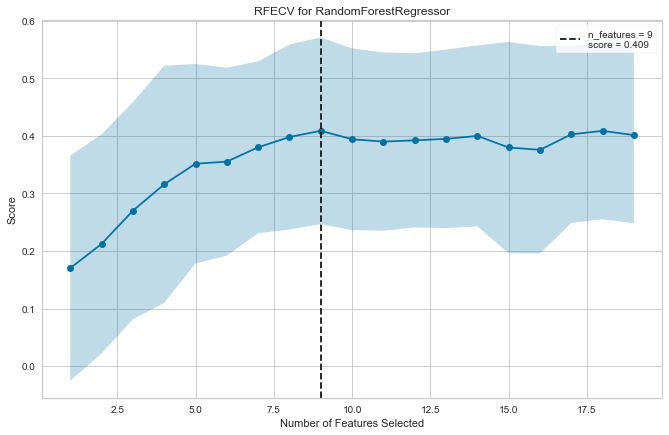

In [245]:
# define the RFECV
cv = KFold(n_splits=5, random_state=8, shuffle=True)  # only 5 splits because of small sample size and compute intensive procedure
viz_rfecv = RFECV(RandomForestRegressor(n_estimators=50, n_jobs=-1), cv=cv, scoring='r2', size=(800, 500))

# fit and visualize
viz_rfecv.fit(X_prep.iloc[:, 1:], y_prep)  # don't fit on the players' names (first column)
viz_rfecv.finalize()

--> seems like only 9 features are enough to give a good prediction

In [247]:
# let's view the dropped features

print('Columns to drop:')
display(X_prep.iloc[:, 1:].loc[:, ~viz_rfecv.support_].columns.to_list())

print('Columns to keep:')
display(X_prep.iloc[:, 1:].loc[:, viz_rfecv.support_].columns.to_list())

Columns to drop:


['x0_College/University', 'x0_High School', 'x0_Other Team/Club', 'x0_PG', 'x0_SG', 'x0_PF', 'x0_SF', 'x0_C', 'Age', '3P']

Columns to keep:


['nameOrganizationFrom', 'Tm', 'numberPickOverall', 'FT%', 'PER', '3P%', 'PC-1', 'PC-2', 'PC-3']

### Implement the RFE into the new Preprocessing-Pipeline

In [32]:
preprocessor = ColumnTransformer(
    transformers=[
        # ('passNames', 'passthrough', ['namePlayer']),
        ('onehot_org', onehot_org_pipeline, ['typeOrganizationFrom']),
        ('onehot_pos', onehot_pos_pipeline, ['Pos']),
        ('target', target_pipeline, target_columns),
        ('ordinal', ordinal_pipeline, ordinal_columns),
        ('ratio', ratio_pipeline, ratio_columns_no_corr),
        ('pca', pca_pipeline, corr_columns)],
    remainder='drop',
    n_jobs=-1)


rfe_preprocessor = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('rfe', RFE(estimator=RandomForestRegressor(n_jobs=-1), n_features_to_select=9))
    ]
)

In [ ]:
rfe_preprocessor.fit(X_train, y_train)

In [34]:
column_mask = rfe_preprocessor.named_steps['rfe'].support_
columns = [c for c, b in zip(X_prep.columns[1:], column_mask) if b]
columns

['nameOrganizationFrom', 'Tm', 'numberPickOverall', 'Age', '3P%', 'PER', 'FT%', 'PC-1', 'PC-2']

--> The columns are slightly different (Age for PC-3) because the RFE is fitted on the whole training dataset and not the cv-splitted dataset.

In [35]:
X_prep = pd.DataFrame(rfe_preprocessor.transform(X_train), columns=columns, index=X_train.index)
X_prep.head()

,nameOrganizationFrom,Tm,numberPickOverall,Age,3P%,PER,FT%,PC-1,PC-2
413,4.74e-01,-0.48,41.0,-1.59,-5.08e-01,-0.32,-0.61,2.21,-0.57
195,1.41e+00,0.91,26.0,0.51,-6.38e-03,-0.10,1.33,-1.25,-2.94
197,9.51e-03,1.04,32.0,-0.14,1.62e-02,-5.52,-1.20,7.07,0.73
92,3.39e-01,1.16,13.0,-0.14,1.00e-01,0.20,-0.57,3.41,0.89
146,1.87e+00,-0.29,7.0,-0.85,9.03e-01,-0.12,0.27,-3.20,-2.14


In [36]:
veterans_train_prep_rfe = pd.concat([X_prep, y_prep], axis=1)
veterans_train_prep_rfe.to_csv('../Data/Output/NBA_Player_Stats_Veterans_Train_Prep_RFE.csv')

## 4. Model Selection

Here the PyCaret Package comes into play. In a separate notebook the preprocessed DataFrame was given to the PyCaret setup and different Regressor models were tested. The most promising models are included in this Deep Dive, that evaluates 9 different regression algorithms with a Cross-Validation.

In [44]:
# list the models to be tested
models = []
models.append(('Dummy', DummyRegressor()))
models.append(('LR', LinearRegression()))
models.append(('Forest', RandomForestRegressor()))
models.append(('XTrees', ExtraTreesRegressor()))
models.append(('AdaBoost', AdaBoostRegressor()))
models.append(('LightGBM', LGBMRegressor()))
models.append(('CatBoost', CatBoostRegressor()))
models.append(('GB', GradientBoostingRegressor()))
models.append(('XGB', XGBRegressor()))

In [45]:
# loop through models and cross-evaluate R2-Score
for model_name, regressor in models:
    regressor_pipeline = Pipeline(
        steps=[('preprocessor', rfe_preprocessor),  # build the final pipeline
               ('regressor', regressor)])
    full_pipeline = TransformedTargetRegressor(regressor=regressor_pipeline, transformer=PowerTransformer(method='yeo-johnson'))  # transform target variable

    scores = cross_val_score(full_pipeline, X_train, y_train, scoring='r2', cv=3, n_jobs=-1, error_score='raise')  # evaluate model
    print(f'Model: {model_name} Score: {round(np.mean(scores), 2)} (Std.: {round(np.std(scores), 2)})')  # report performance

Model: Dummy Score: -0.02 (Std.: 0.01)
Model: LR Score: 0.01 (Std.: 0.23)
Model: Forest Score: 0.32 (Std.: 0.11)
Model: XTrees Score: 0.32 (Std.: 0.1)
Model: AdaBoost Score: 0.24 (Std.: 0.11)
Model: LightGBM Score: 0.22 (Std.: 0.1)
Model: CatBoost Score: 0.26 (Std.: 0.12)
Model: GB Score: 0.26 (Std.: 0.12)
Model: XGB Score: 0.18 (Std.: 0.15)


--> The best models are then combined as an ensemble (VotingRegressor) to balance the predictions

## 5. Building an Ensemble Meta-Estimator

A voting regressor is an ensemble meta-estimator that fits several base regressors, each on the whole dataset. Then it averages the individual predictions to form a final prediction. This can boost model performance and stabilize the predictions (lower variance), especially when combining different sorts of ML algorithms (tree-based & linear, bagging & boosting, etc.).

In [85]:
# best models (this combination works best)
ensemble_models = []
# ensemble_models.append(('CatBoost', CatBoostRegressor()))
ensemble_models.append(('GB', GradientBoostingRegressor()))
ensemble_models.append(('Forest', RandomForestRegressor()))
# ensemble_models.append(('XTrees', ExtraTreesRegressor()))

# ensemble
ensemble = VotingRegressor(estimators=ensemble_models, weights=[1, 2], n_jobs=-1)  # weight the better scoring algorithm double

# pipeline
regressor_pipeline = Pipeline(
    steps=[('rfe_preprocessor', rfe_preprocessor),  # build the final pipeline
            ('regressor', ensemble)])
full_pipeline = TransformedTargetRegressor(regressor=regressor_pipeline, transformer=PowerTransformer(method='yeo-johnson'))  # transform target variable

# scores
scores = cross_val_score(full_pipeline, X_train, y_train, scoring='r2', cv=3, n_jobs=-1, error_score='raise')  # evaluate model
print(f'Ensemble Score: {round(np.mean(scores), 2)} (Std.: {round(np.std(scores), 2)})')  # report performance

Ensemble Score: 0.33 (Std.: 0.11)


--> The ensemble gave an improvement from a basic Random Forest (R2=0.32) to an ensemble (R2=0.33). Not much (and it can be due to the stochastic nature of the algorithm), but we'll take it because it probably generalizes better on unseen data (lower variance). The improvement of score could be due to the different nature of the ensemble methods (Forest=Bagging, Gradient Boosting=Boosting) that balance each others predictions quiet well.

## 6. Hyperparamertuning

Building the preprocessing and modelling in a pipeline is not only good to reuse the whole process and avoid data leakage, it also plays a vital role in hyperparametertuning: all parameters of the preprocessing can be permutated and tested in a cross-vaidated manner as well (not just the model).

One "disadvantage" is that there are now a lot more hyperparameters that can be tested which may inflate the gridsearch to an extend that the computing ressources are too limied to test all versions. That's why RandomizedSearchCV was applied.

In [ ]:
# fit it for parameter inspection
full_pipeline.fit(X_train, y_train)

In [87]:
# get all parameters of the pipeline
sorted(full_pipeline.get_params().keys())

['check_inverse', 'func', 'inverse_func', 'regressor', 'regressor__memory', 'regressor__regressor', 'regressor__regressor__Forest', 'regressor__regressor__Forest__bootstrap', 'regressor__regressor__Forest__ccp_alpha', 'regressor__regressor__Forest__criterion', 'regressor__regressor__Forest__max_depth', 'regressor__regressor__Forest__max_features', 'regressor__regressor__Forest__max_leaf_nodes', 'regressor__regressor__Forest__max_samples', 'regressor__regressor__Forest__min_impurity_decrease', 'regressor__regressor__Forest__min_samples_leaf', 'regressor__regressor__Forest__min_samples_split', 'regressor__regressor__Forest__min_weight_fraction_leaf', 'regressor__regressor__Forest__n_estimators', 'regressor__regressor__Forest__n_jobs', 'regressor__regressor__Forest__oob_score', 'regressor__regressor__Forest__random_state', 'regressor__regressor__Forest__verbose', 'regressor__regressor__Forest__warm_start', 'regressor__regressor__GB', 'regressor__regressor__GB__alpha', 'regressor__regresso

In [106]:
# specify the parameter grid
param_grid = {}

# Preprocessing-Parameters for Imputation
param_grid['regressor__rfe_preprocessor__preprocessor__ratio__KNNI__n_neighbors'] = [1, 2, 3]
param_grid['regressor__rfe_preprocessor__preprocessor__pca__ratio_pipeline__KNNI__n_neighbors'] = [1, 2, 3]
param_grid['regressor__rfe_preprocessor__preprocessor__target__KNNI_numeric__n_neighbors'] = [1, 2, 3]

# Preprocessing-Parameters for Encoding
param_grid['regressor__rfe_preprocessor__preprocessor__onehot_org__OHE_Org__drop'] = ['if_binary', 'first']
param_grid['regressor__rfe_preprocessor__preprocessor__onehot_pos__OHE_Pos__drop'] = ['if_binary', 'first']

# Preprocessing-Parameters for PCA
param_grid['regressor__rfe_preprocessor__preprocessor__pca__pca__n_components'] = [3, 4, 5, 6, 7, 8]

# Preprocessing-Parameters for RFE
param_grid['regressor__rfe_preprocessor__rfe__n_features_to_select'] = [9, 10, 11, 12, 13, 14, 15]
param_grid['regressor__rfe_preprocessor__rfe__estimator'] = [GradientBoostingRegressor(), RandomForestRegressor()]

# Estimator-Parameters for Ensemble (Forest)
param_grid['regressor__regressor__Forest__max_features'] = ['auto', 'sqrt', 'log2']
param_grid['regressor__regressor__Forest__criterion'] = ['squared_error', 'absolute_error']
param_grid['regressor__regressor__Forest__min_samples_leaf'] = [1, 2, 4, 6]
param_grid['regressor__regressor__Forest__min_samples_split'] = [2, 5, 10]

# Estimator-Parameters for Ensemble (Gradient Boosting)
param_grid['regressor__regressor__GB__loss'] = ['squared_error', 'absolute_error']
param_grid['regressor__regressor__GB__max_features'] = ['auto', 'sqrt', 'log2']
param_grid['regressor__regressor__GB__criterion'] = ['squared_error', 'absolute_error']
param_grid['regressor__regressor__GB__min_samples_leaf'] = [1, 2, 4, 6]
param_grid['regressor__regressor__GB__min_samples_split'] = [2, 5, 10]


# final max. permutations
print(f'The numer of max. permutations is: {len(ParameterGrid(param_grid))}.')

The numer of max. permutations is: 94058496.


In [107]:
# actual RandomizedSearchCV
cv = KFold(n_splits=5, random_state=8, shuffle=True)  # only 5 splits because of small sample size
grid = RandomizedSearchCV(full_pipeline, param_distributions=param_grid, cv=cv, n_iter=500, error_score=0.0, n_jobs=-1)  # error_score for impossible parameter combinations
grid.fit(X_train, y_train)

RandomizedSearchCV(cv=KFold(n_splits=5, random_state=8, shuffle=True),
                   error_score=0.0,
                   estimator=TransformedTargetRegressor(regressor=Pipeline(steps=[('rfe_preprocessor',
                                                                                   Pipeline(steps=[('preprocessor',
                                                                                                    ColumnTransformer(n_jobs=-1,
                                                                                                                      transformers=[('onehot_org',
                                                                                                                                     Pipeline(steps=[('SI',
                                                                                                                                                      SimpleImputer(fill_value='missing',
                                                        

In [108]:
# Best Hyperparameters
print(f'The best hyperparameter combination is: \n {grid.best_params_} \n\n with a maximum score of {round(grid.best_score_, 3)} (R2).')

The best hyperparameter combination is: 
 {'regressor__rfe_preprocessor__rfe__n_features_to_select': 12, 'regressor__rfe_preprocessor__rfe__estimator': RandomForestRegressor(), 'regressor__rfe_preprocessor__preprocessor__target__KNNI_numeric__n_neighbors': 2, 'regressor__rfe_preprocessor__preprocessor__ratio__KNNI__n_neighbors': 1, 'regressor__rfe_preprocessor__preprocessor__pca__ratio_pipeline__KNNI__n_neighbors': 1, 'regressor__rfe_preprocessor__preprocessor__pca__pca__n_components': 3, 'regressor__rfe_preprocessor__preprocessor__onehot_pos__OHE_Pos__drop': 'if_binary', 'regressor__rfe_preprocessor__preprocessor__onehot_org__OHE_Org__drop': 'first', 'regressor__regressor__GB__min_samples_split': 2, 'regressor__regressor__GB__min_samples_leaf': 1, 'regressor__regressor__GB__max_features': 'auto', 'regressor__regressor__GB__loss': 'squared_error', 'regressor__regressor__GB__criterion': 'squared_error', 'regressor__regressor__Forest__min_samples_split': 2, 'regressor__regressor__Forest_

In [114]:
# Inspecting the best Parameter-Combinations
grid_results = pd.concat([pd.DataFrame(grid.cv_results_['mean_test_score'], columns=['R2']), pd.DataFrame(grid.cv_results_['params'])], axis=1)
grid_results.sort_values(by=['R2'], ascending=False, inplace=True, ignore_index=True)
grid_results.index = ['Model Rank No. ' + str(col + 1) for col in grid_results.index]
grid_results.head(10).T

,Model Rank No. 1,Model Rank No. 2,Model Rank No. 3,Model Rank No. 4,Model Rank No. 5,Model Rank No. 6,Model Rank No. 7,Model Rank No. 8,Model Rank No. 9,Model Rank No. 10
R2,0.37,0.37,0.37,0.37,0.37,0.36,0.36,0.36,0.36,0.36
regressor__rfe_preprocessor__rfe__n_features_to_select,12,11,13,14,12,15,9,11,11,10
regressor__rfe_preprocessor__rfe__estimator,RandomForestRegressor(),RandomForestRegressor(),GradientBoostingRegressor(),GradientBoostingRegressor(),GradientBoostingRegressor(),GradientBoostingRegressor(),GradientBoostingRegressor(),GradientBoostingRegressor(),RandomForestRegressor(),GradientBoostingRegressor()
regressor__rfe_preprocessor__preprocessor__target__KNNI_numeric__n_neighbors,2,3,3,2,2,2,1,2,2,3
regressor__rfe_preprocessor__preprocessor__ratio__KNNI__n_neighbors,1,1,2,3,1,2,3,1,1,3
regressor__rfe_preprocessor__preprocessor__pca__ratio_pipeline__KNNI__n_neighbors,1,3,1,3,2,3,2,2,2,3
regressor__rfe_preprocessor__preprocessor__pca__pca__n_components,3,3,5,3,5,6,3,4,3,3
regressor__rfe_preprocessor__preprocessor__onehot_pos__OHE_Pos__drop,if_binary,first,if_binary,first,if_binary,if_binary,first,if_binary,first,first
regressor__rfe_preprocessor__preprocessor__onehot_org__OHE_Org__drop,first,first,if_binary,first,first,first,first,if_binary,if_binary,first
regressor__regressor__GB__min_samples_split,2,5,10,10,2,2,10,2,2,10


## 7. Model Evaluation

Now that the best model pipeline was grid searched and the best estimator is found, we need to save the model and train it on the train set before testing the final performance on the train set. The pipeline is saved as a serilaized pickle-file to reuse it if needed.

In [115]:
# save the pipeline to disk
filepath = '../Models/NBA_Rookie_finalized_model_pipeline.pkl'
joblib.dump(grid.best_estimator_, filepath)
 
# load the model from disk to check if it's working
final_model = joblib.load(filepath)

In [ ]:
# train the model on the whole training dataset
final_model.fit(X_train, y_train)

In [123]:
# load the test set
NBA_Player_Stats_Veterans_Test = pd.read_csv('../Data/Output/NBA_Player_Stats_Veterans_Test.csv', index_col=0)
display(NBA_Player_Stats_Veterans_Test.head(3))

# define objects for score
X_test = NBA_Player_Stats_Veterans_Test.drop('Career_PER', axis=1)
y_test = NBA_Player_Stats_Veterans_Test['Career_PER']

,namePlayer,numberPickOverall,nameOrganizationFrom,typeOrganizationFrom,Age,Tm,Pos,G,GS,MP,FG,FG%,3P,3P%,2P,2P%,eFG%,FT,FT%,ORB,DRB,AST,STL,BLK,TOV,PF,PTS,PER,WS,WS/48,Career_PER
338,Hakim Warrick,19.0,Syracuse,College/University,23.0,MEM,PF,68.0,2.0,10.6,1.5,0.44,0.0,NaN,1.5,0.44,0.44,1.1,0.66,0.6,1.5,0.4,0.2,0.3,0.8,1.7,4.1,11.0,0.8,0.05,15.5
30,Emmanuel Mudiay,7.0,Guangdong Southern Tigers,Other Team/Club,19.0,DEN,PG,68.0,66.0,30.4,4.8,0.36,1.1,0.32,3.8,0.38,0.40,2.1,0.67,0.5,2.9,5.5,1.0,0.5,3.2,2.1,12.8,9.9,-2.1,-0.05,11.8
495,DeShawn Stevenson,23.0,Washington Union,High School,19.0,UTA,SG,40.0,2.0,7.3,0.8,0.34,0.0,0.08,0.8,0.38,0.35,0.7,0.68,0.2,0.5,0.5,0.3,0.1,0.7,0.7,2.2,4.3,-0.4,-0.07,9.9


In [124]:
# test the model skill on the test set
print(f'R2: {round(final_model.score(X_test, y_test), 3)}')

R2: 0.444


--> The model performance on unseen data is slightly higher than the auto-ml model from PyCaret (~0.015)!

--> It is also 0.04 higher than the train score from the RandomizedSearch which indicates that the samples differ from each other or the sample number is too low.

## 8. Model Inspection

During the model inspecton we try to get an understanding of the model and it's prediction (error). With this new information we could try a new version and refinements during the next iteration the lifecycle of the model. 

We use 3 plots to answer the following questions:

- **Residuals Plot**: What is the distribution of the residuals? Are test set ans train set comparable? Are the residuals independent, or is there a systematic error in the data/prediction?
- **Prediction Error Line**: Shows the linear relationship of the errors compared to the "best fit". In which direction did the model go wrong? Were the predictions to strong (underestimating losers and overestimating winners) or too weak?
- **Learning Curve**: The learning curve shows how good the model generalized from the learnings of the train set to the test set. Do we need more data?

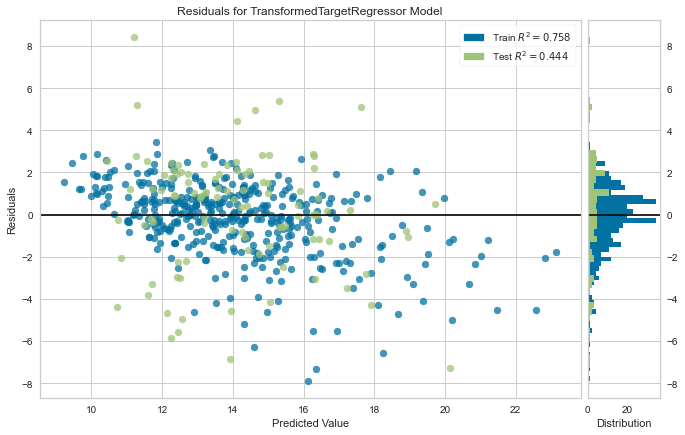

In [129]:
# inspect the residuals plot
res_plot = ResidualsPlot(final_model, size=(800, 500))
res_plot.fit(X_train, y_train)
res_plot.score(X_test, y_test)
res_plot.finalize()

--> The residuals are at max. gaussian-like, but not gaussian (especially not for the test set). The distribution is relatively symmetrical but there are quite strong outliers up to 8 SD. This means that the model predicts talented players (high PER) as bad as untalented players (low PER). Also, the test set shows a flat distribution which means that low and high errors are almost equally likely. Furthermore, the residuals don't seem to be independent: the higher the predicted PER, the higher the negative error, which means the model sees a promised talent in a player in his first year (Rookie) but still underestimates the Career PER of the player.

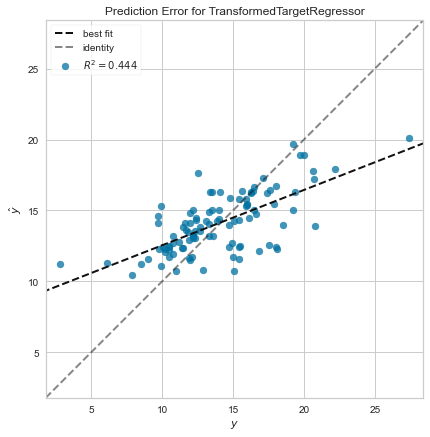

In [133]:
# inspect the prediction error
pred_error = PredictionError(final_model, size=(500, 500))
pred_error.fit(X_train, y_train)
pred_error.score(X_test, y_test)
pred_error.finalize()

--> The prediction error graphs supports the conclusions from the residuals plot: The model overestimates rookies that will end up as sub-average players and the model also understimates rookies that will be above average regarding their career PER. That's precisely the reason why the R2 score is only 0.44, since R2 is relative to the error one have gotten when just taking the average career PER.

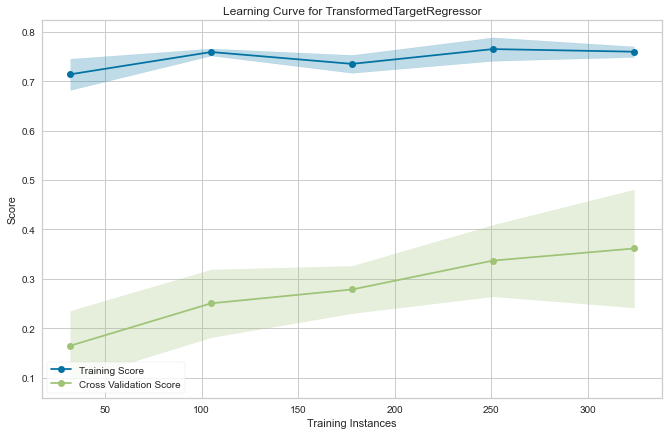

In [135]:
# inspect the learning curve
cv = KFold(n_splits=5 ,random_state=8, shuffle=True)
learn_curve = LearningCurve(final_model, cv=cv, scoring='r2', n_jobs=-1, size=(800, 500))
learn_curve.fit(X_train, y_train)
learn_curve.finalize()

--> Here we can see quite a generalization gap from training to testing (approximately 0.4 R2). The green curve of the cv-score is steadily increasing which indicates that we should use more data to boost the cv-score further towards the train score. More data usually means more generalization and better results on the test set since the model had more data to learn and extract the signal from.

## 9. Finalization & Prediction

Now that we have a model skill (R2) on the test set we can finally use the pipeline to actually predict the current rookies career PER. To get a better prediction we need to use all of the available data to train the model, of course. That means we combine the train set and the test set and fit the pipeline once again for a final training on the whole dataset before prediction. 

To reuse the pipeline with all it's parameters we also serialize and save it as a pickle-file.

In [146]:
# train the model on the whole data
X = pd.concat([X_train, X_test], axis=0)
y = pd.concat([y_train, y_test], axis=0)

# fit the final model
final_model = final_model.fit(X, y)

# save the final model
filepath = '../Models/NBA_Rookie_finalized_model_pipeline.pkl'
joblib.dump(final_model, filepath)
 
# load the model from disk to check if it's working
final_model = joblib.load(filepath)

In [141]:
# load the current rookie data
NBA_Player_Stats_Rookies = pd.read_csv('../Data/Output/NBA_Player_Stats_Rookies.csv', index_col=0)
NBA_Player_Stats_Rookies.head(3)

,namePlayer,numberPickOverall,nameOrganizationFrom,typeOrganizationFrom,Age,Tm,Pos,G,GS,MP,FG,FG%,3P,3P%,2P,2P%,eFG%,FT,FT%,ORB,DRB,AST,STL,BLK,TOV,PF,PTS,PER,WS,WS/48,Career_PER
0,Anthony Edwards,1.0,Georgia,College/University,19.0,MIN,SG,72.0,55.0,32.1,7.0,0.42,2.4,0.33,4.6,0.48,0.49,2.9,0.78,0.8,3.8,2.9,1.1,0.5,2.2,1.8,19.3,13.9,0.8,0.02,13.9
1,James Wiseman,2.0,Memphis,College/University,19.0,GSW,C,39.0,27.0,21.4,4.9,0.52,0.3,0.32,4.6,0.54,0.54,1.4,0.63,1.4,4.4,0.7,0.3,0.9,1.5,3.1,11.5,13.1,0.7,0.04,13.1
2,LaMelo Ball,3.0,Illawarra,Other Team/Club,19.0,CHO,PG,51.0,31.0,28.8,5.7,0.44,1.8,0.35,3.9,0.49,0.50,2.5,0.76,1.2,4.7,6.1,1.6,0.4,2.8,2.7,15.7,17.5,2.8,0.09,17.5


In [160]:
# predict the current rookies and display the most important features to get an overall impression
predictions_y = pd.DataFrame(final_model.predict(NBA_Player_Stats_Rookies), columns=['Predicted_Career_PER'], index=NBA_Player_Stats_Rookies.index)
rookie_X = NBA_Player_Stats_Rookies[['namePlayer', 'numberPickOverall', 'Age', 'Tm', 'Pos', 'Career_PER']]
predictions = pd.concat([rookie_X, predictions_y], axis=1).rename({'Career_PER': 'Rookie_PER'}, axis=1)
predictions.sort_values(by='Predicted_Career_PER', ascending=False).head(10)

,namePlayer,numberPickOverall,Age,Tm,Pos,Rookie_PER,Predicted_Career_PER
2,LaMelo Ball,3.0,19.0,CHO,PG,17.5,19.48
15,Isaiah Stewart,16.0,19.0,DET,C,16.4,17.07
5,Onyeka Okongwu,6.0,20.0,ATL,C,16.8,16.69
11,Tyrese Haliburton,12.0,20.0,SAC,PG,16.2,16.32
45,Kenyon Martin Jr.,52.0,20.0,HOU,SF,14.6,16.07
20,Tyrese Maxey,21.0,20.0,PHI,SG,14.5,15.56
23,Immanuel Quickley,25.0,21.0,NYK,PG,15.8,15.43
0,Anthony Edwards,1.0,19.0,MIN,SG,13.9,15.14
1,James Wiseman,2.0,19.0,GSW,C,13.1,14.87
52,Jalen Harris,59.0,22.0,TOR,SG,15.2,14.76


--> It can be expected that those players will have an acutally higher PER over their Career since the model underestimates high potential (see residual plot) more than low potential. Also the PER Ratings are quite low compared to top notch players currently ranking in 25-27 PER (Lebron James, Kevin Durant, Anthony Davis, etc.).

## 10. Visualizing the Pipeline

Summarizing the final pipeline as an HTML-file and show it in the IPython output as an interactive viz.

This gives a good overview of the whole preprocessing and modelling with it's final decisions.

In [139]:
# visualizing the pipeline

filename = 'NBA_Rookie_model_pipeline.html'

with open('../Models/' + filename, 'w') as f:  
    f.write(estimator_html_repr(final_model))

display(HTML(open('../Models/' + filename).read()))

## 11. Conclusion

This project tried to answer the question: "What is the Career Performance of a Rookie going to be like?". The predictors were player performance metrics from his rookie season, as well as data from the Draft (college, nba team, pick, etc.). The target was the Player Efficiency Rating (PER) averaged over the whole career.

The best model tested was an Ensemble VotingRegressor (GradientBoostingRegressor + RandomForestRegressor) with a R2 of 0.44 (rounded), slightly better than the results from the auto-ml library PyCaret.

Predicting a players career is a hard task because it depends on much more than only his first year stats. Injuries, Lifestyle, Marketing and Teammates all contribute to the long term success of a player and weren't a variable in the prediction model. Furthermore, the data cutoff (veterans >= 5 years of experience) was reasoned but can be extended or lessened for further tests. Also, the players were drafted 2001 or later which could also be extended the 90's to get more data and probably a more stable estimator (generalization).